# Inferential statistics II - Bootstrapping

## Introduction

In the previous frequentist mini-projects, you did frequentist calculations to perform inference from a sample of data. Such inference relies on theory largely developed from the 19th-Century onwards that is subject to certain assumptions or theoretical limits. These are fine if those assumptions hold for the particular case you're working on, and what you want to do has a known theoretical distribution (for example the mean of a sampling distribution that we looked at in the previous mini-project.)

In this mini-project, you'll use the same medical charge data you used in the frequentist inference mini-project, but this time you'll make inferences about the population using bootstrapping (ie. simulating repeated re-runs of an experiment.) If frequentism is about using assumptions and theoretical results to calculate what we expect to happen were an experiment to be run again and again and again, then bootstrapping is about using computing power to essentially re-run the sample draw again and again and again to see what actually happens.

## Prerequisites

While these exercises do not strictly depend on these concepts, we encourage you to complete the previous mini-projects before starting this one so that you can approach this assignment with a good understanding of frequentist concepts like:
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate confidence intervals and p-values
* how those confidence intervals and p-values allow you to perform hypothesis (or A/B) tests

To complete mini-project, it's important that you first complete the bootstrap resources listed in this subunit, as they contain valuable information about how to calculate bootstrap replicates of summary statistics. Having an basic understanding of what confidence intervals and p-values are will also be helpful (we touch on them in this mini-project, but please speak to your mentor or conduct individual research if you'd like to learn more.) 

In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
from scipy import stats
import matplotlib.pyplot as plt

## Medical charge data set

In [2]:
med_charges = pd.read_csv('data/insurance2.csv')

In [3]:
med_charges.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In the previous assignment, you used the frequentist approach to estimate the lower limit for the 95% confidence interval on the mean hospital charge. This approach relies on statistical theory that has been developed over the years and is also limited to statistics for which theoretical results on the sampling distribution exist. These results are remarkably useful and applicable much of the time and under a surprisingly wide range of conditions.

Having calculated the 95% lower confidence interval using frequentist theory in the previous exercise, you'll now use bootstrap inference to verify your calculations and check that you get consistent results without making the assumptions required before. After all, the distribution of charges really was very non-normal.

__Q:__ Use bootstrap sampling to estimate the same 95% confidence interval lower limit as before.

__A:__ Use `conf_int = np.percentile(bs_replicates, [5]) # 95% lower limit`

In [4]:
# Define a function we can use again
def draw_bs_reps(data, func, size=1):
    """
    Draw bootstrap replicates.
      data = one-dimensional array of values
      func = the function to run on each replicate, e.g. mean
      size = the number of replicates to draw (generate) 
    """

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = func(
                            np.random.choice(
                                data, size=len(data)
                           ))

    return bs_replicates
#end_def

In [5]:
# Draw 10000 replicates of medical charges and
# calculate the 95% lower confidence interval 
np.random.seed(47)
N_rep = 10000

bs_replicates = draw_bs_reps(med_charges.charges, np.mean, N_rep)
conf_int = np.percentile(bs_replicates, [5]) # 95% lower limit

conf_int

array([12724.4679217])

If you performed 10000 replicates immediately after setting the random seed to 47, you should get the value 12724 here, which compares very well with the value 12725 obtained using the _t_-distribution confidence interval previously. It is a most pleasant result to see the predictions of classical frequentist theory match with results that are now possible through the number-crunching ability of computers.

Remember, in the previous mini-projects, we saw that there are two ways of performing a _t_-test from a sample, depending on whether we can assume the groups have equal variance or not. We can actually easily test this using the bootstrap approach!

__Q:__ Calculate the 95% confidence interval for the difference between the standard deviations of insurance and non-insurance claim charges (insured - non-insured). Calculate the differences over 10000 replicates. Plot the histogram of values and mark the locations of the percentiles. State the null and alternative hypothesis and comment on whether you would retain or reject the null hypothesis in this case and why.

__A:__ The null hypothesis: there is no difference between the standard deviations of insurance and non-insurance claim charges.

In [6]:
# not insured
ins0 = med_charges.loc[med_charges.insuranceclaim == 0]

# not insured
ins1 = med_charges.loc[med_charges.insuranceclaim == 1]


In [7]:
np.random.seed(47)
N_rep = 10000

nonins_bs_replicates = draw_bs_reps(ins0.charges, np.std, N_rep)
ins_bs_replicates = draw_bs_reps(ins1.charges, np.std, N_rep)

diffs = ins_bs_replicates - nonins_bs_replicates

print("insured\n", ins_bs_replicates)
print("not insured\n", nonins_bs_replicates)
print("diffs\n", diffs)

insured
 [14165.0062503  14176.49758651 14109.56522567 ... 14112.40608661
 14420.49156918 14163.2373204 ]
not insured
 [6159.05411195 6115.51989319 6642.76007193 ... 6510.627812   6371.59338214
 6269.25813899]
diffs
 [8005.95213835 8060.97769333 7466.80515375 ... 7601.77827461 8048.89818704
 7893.97918141]


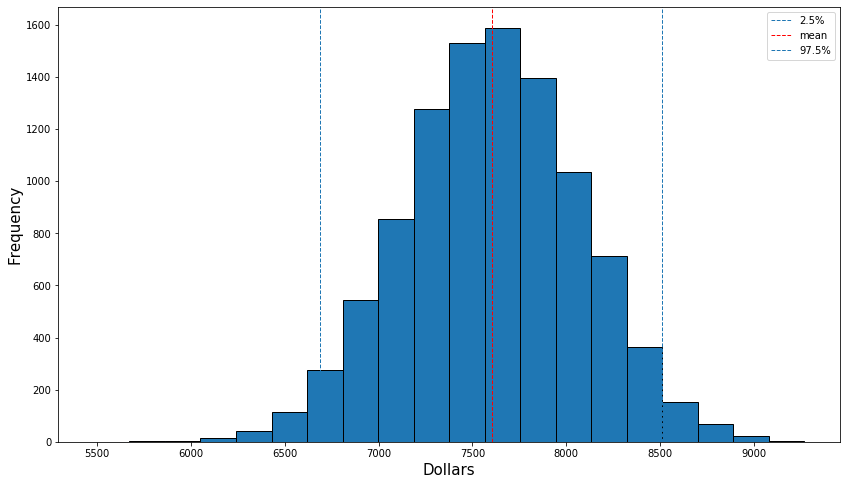

In [8]:
axvline_kwargs = {"linestyle" : "dashed", "linewidth" : "1"} 
diffs_s = pd.Series(diffs)
diffs_s.hist(bins=20, grid=False,
           figsize=(14,8), xlabelsize=10, edgecolor='k')
plt.xlabel("Dollars", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.axvline(np.percentile(diffs_s, [97.5]), **axvline_kwargs, label="2.5%")
plt.axvline(diffs_s.mean(), **axvline_kwargs, color="red", label="mean")
plt.axvline(np.percentile(diffs_s, [2.5]), **axvline_kwargs, label="97.5%")
plt.legend(loc='upper right')
plt.show()

In [9]:
conf_int = np.percentile(diffs, [2.5, 97.5]) # 95% 
lower, upper = conf_int
print("The 95% confidence interval is between", round(lower,2), "and", round(upper,2))

The 95% confidence interval is between 6685.46 and 8510.07


A: There is definitely a difference between the standard deviations of insurance and non-insurance claim charges. A difference of anything close to 0 isn't even on the plot.

----------------------

## Confidence interval,  $\alpha$, and p-value

The **confidence interval** is often a useful quantity to estimate. We wish to limit our expected probability of making a Type I error<sup>[1]</sup> to alpha ($\alpha$)<sup>[2]</sup>. The associated confidence interval is our estimate of the interval within which we expect the true population value to be found (1 - $\alpha$) $\times$ 100 % of the time we do this test. 

In the exercise above, we performed bootstrap replicates to estimate the interval and reject the null hypothesis if this interval did not contain zero. You will sometimes see such an interval reported in the output of statistical functions.

The partner of the confidence interval is the p-value. The p-value and the confidence interval are linked through our choice of $\alpha$. The p-value tells us how likely it is, under the null hypothesis, to get an outcome at least as extreme as what was observed. If this fails to reach the level of our _pre-specified_ $\alpha$, we decide the null hypothesis is sufficiently unlikely to be true and thus reject it. To calculate this p-value via the bootstrap, we have to put ourselves in a position where we are simulating the null hypothesis being true and then calculate the fraction of times we observe a result at least as extreme as that actually observed.

Remember how, previously, you used the _t_-test to calculate the p-value for the observed difference between the means of insured and non-insured medical cases. We're now going to repeat this, this time using the bootstrap approach.

<sup>[1]</sup> Type 1 error: where we wrongly reject the null hypothesis, and it is, instead, true)
<br>
<sup>[2]</sup> alpha ($\alpha$) is the desired significance level, typically 0.05 or lower.

See Also: [What is the difference between an alpha level and a p-value? ](https://courses.washington.edu/p209s07/lecturenotes/Week%205_Monday%20overheads.pdf)

__Q:__ Perform a bootstrapped hypothesis test at the 5% significance level ($\alpha = 0.05$) to calculate the p-value of the observed difference between insurance and non-insurance charges, state your null and alternative hypotheses and whether you retain or reject the null hypothesis for the given significance level.


__A:__ 
The null hypothesis: there is no significant difference between insurance and non-insurance charges. (The difference seen in the dataset is due to chance.)

The alernative hypothesis: there is a significant difference between insurance and non-insurance charges.

<blockquote>
    To do the two-sample bootstrap test, we shift both arrays to have the same mean, since we are simulating the hypothesis that their means are, in fact, equal. We then draw bootstrap samples out of the shifted arrays and compute the difference in means. This constitutes a bootstrap replicate, and we generate many of them. The p-value is the fraction of replicates with a difference in means greater than or equal to what was observed.
</blockquote> 

reference: 
[DataCamp Statistical thinking in Python, part 2](https://campus.datacamp.com/courses/statistical-thinking-in-python-part-2)

Null hypothesis: charges are identically distributed between insured and uninsured patients (there are no differences due to insurance; shuffling samples shouldn't matter.)

Test statistic: if the populations are "identical", they should have the same mean charge. The difference in mean charge should be 0.

   1. Use the function, `diff_of_means` to compute the empirical difference of means that was observed between charges for insured vs uninsured patients in the original dataset.
   2. Shift both arrays to have the same mean
   3. Draw 10,000 replicates out of the shifted arrays.
   4. Use the function, `diff_of_means` to compute the difference of means for he N permuted samples.
   5. Compare the differences from the original data with the randomly computed differences.
   6. Compute the p-value as the fraction of replicates with a difference in means greater than or equal to what was observed

In [10]:
# Define the functions we will use

def diff_of_means(data_1, data_2):
    """
    Difference in means of two arrays.
    data1 - data2
    """

    # The difference of means of data_1, data_2
    diff = np.mean(data_1) - np.mean(data_2)

    return diff
#end_def

In [11]:
# not insured
# ins0.charges is the Series/array of interest
ins0 = med_charges.loc[med_charges.insuranceclaim == 0]
ins0_charges = ins0.charges.values # numpy array

# not insured
# ins1.charges is the Series/array of interest
ins1 = med_charges.loc[med_charges.insuranceclaim == 1]
ins1_charges = ins1.charges.values # numpy array


In [12]:
# Compute empirical (observed in the data we have) difference in means
# Use absolute value bcause we don't care (or pretend not to know)
# which way the difference goes.
empirical_diff_means = diff_of_means(ins1.charges, ins0.charges)

# Mean of all charges (if insurance doesn't matter, this is relevant)
# This is equivalent to the mean of the concatenated sub-populations
mean_charges = np.mean(med_charges.charges)

# Generate shifted arrays
ins0_shifted = ins0_charges - np.mean(ins0_charges) + mean_charges
ins1_shifted = ins1_charges - np.mean(ins1_charges) + mean_charges


In [13]:
# Compute 10,000 bootstrap replicates from shifted arrays
nonins_bs_replicates = draw_bs_reps(ins0_shifted, np.mean, size=10000)
ins_bs_replicates = draw_bs_reps(ins1_shifted, np.mean, size=10000)

# Get replicates of difference of means
# subtracing in the same order as for empirical_diff_means
bs_replicates_diff = ins_bs_replicates - nonins_bs_replicates

# Compute and print p-value
p = np.sum(bs_replicates_diff >= empirical_diff_means) / len(bs_replicates_diff)

print('p-value =', p)

p-value = 0.0


We reject the null hypothesis for the given significance level.

__Q:__ To put the above result in perspective, plot the histogram of your bootstrapped differences along with lines marking the locations of the observed difference. (Why would we plot more than one line, given that we only have one observed difference?)

__A:__ "Why would we plot more than one line, given that we only have one observed difference?)"

I have no idea.

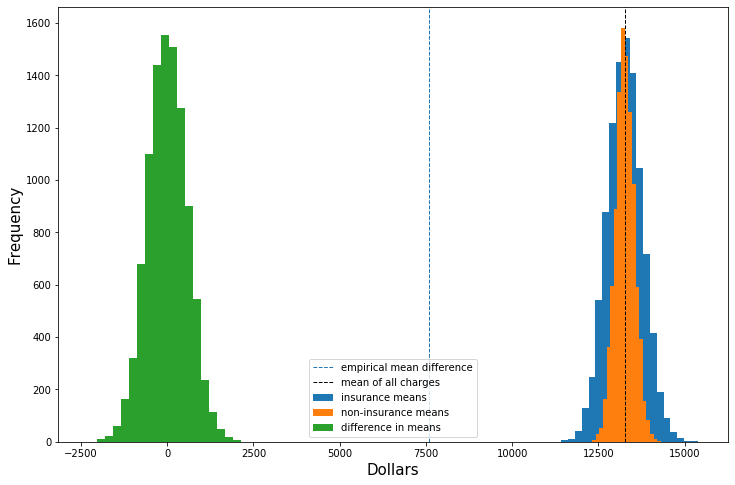

In [14]:
axvline_kwargs = {"linestyle" : "dashed", "linewidth" : "1"} 

plt.figure(figsize=(12,8))

plt.hist(ins_bs_replicates, bins=20, label="insurance means")
plt.hist(nonins_bs_replicates, bins=20, label="non-insurance means")
plt.hist(bs_replicates_diff, bins=20, label="difference in means")
plt.xlabel("Dollars", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.axvline(empirical_diff_means, **axvline_kwargs, label="empirical mean difference")
plt.axvline(mean_charges, **axvline_kwargs, color="k", label="mean of all charges")
plt.legend(loc='best')
plt.show()


__Q:__ Compare your p-value above with that obtained using the _t_-test function in the previous assignment. Do you think you would want to try to perform enough bootstrap replicates to observe a random difference as large as that we did observe?

__A:__ In the previous assignment, I got the p-value, 4.46e-31. This time, I got 0.0.

They're effectively equivalent.

I see no reason to perform more bootstrap replicates. 

<blockquote>
    The number of bootstrap samples recommended in literature has increased as available computing power has increased. If the results may have substantial real-world consequences, then one should use as many samples as is reasonable, given available computing power and time. Increasing the number of samples cannot increase the amount of information in the original data; it can only reduce the effects of random sampling errors which can arise from a bootstrap procedure itself. Moreover, there is evidence that numbers of samples greater than 100 lead to negligible improvements in the estimation of standard errors. In fact, according to the original developer of the bootstrapping method, even setting the number of samples at 50 is likely to lead to fairly good standard error estimates.

[Wikipedia](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#Recommendations)
</blockquote>

**Why did we do a boostrap test? Why not a permuation test?**

Try a permuation test. According o Stack Exchange, "The permutation test is best for testing hypotheses and bootstrapping is best for estimating confidence intervals."

"Permutation tests test a specific null hypothesis of exchangeability, i.e. that only the random sampling/randomization explains the difference seen."

Permutation tests requie that we have wo sample arrays (which we do) and cannot look for a difference in distribution (which we don;t care about here).

In [15]:
# not insured
ins0 = med_charges.loc[med_charges.insuranceclaim == 0]

# not insured
ins1 = med_charges.loc[med_charges.insuranceclaim == 1]

# we don't need to concatenate the populations; 
# they're already mixed in the original dataset
# but for purposes of writing a moe generic function, we'll
# separate and concatnate

def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two parts
    # Note position of colons in the slices!
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2= permuted_data[len(data2):]

    return perm_sample_1, perm_sample_2
#end_def

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates
#end_def

# diff_of_means has already been defined

Null hypothesis: charges are identically distributed between insured and uninsured patients (there are no differences due to insurance.

Test statistic: if the populations are "identical", they should have the same mean charge. The difference in mean charge should be 0.

   1. Use the function, diff_of_means to compute the empirical difference of means that was observed between charges for insured vs uninsured patients in the original dataset.
   2. Draw 10,000 permutation replicates, Using the function, diff_of_means to compute the difference of means for the permuted samples.
   4. Compare the differences from the original data with the randomly computed differences.
   5. Compute the p-value.

In [16]:
# Compute empirical difference from dataset 
empirical_diff_means = diff_of_means(ins1.charges, ins0.charges)

# Draw 10,000 permutation replicates
perm_replicates = draw_perm_reps(ins1.charges, ins0.charges,
                                 diff_of_means, size=10000)

# Compute p-value
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

print("p value:", p)


p value: 0.0


In [17]:
observed_diff = np.mean(ins1.charges) - np.mean(ins0.charges)
observed_diff 

7602.506384231368

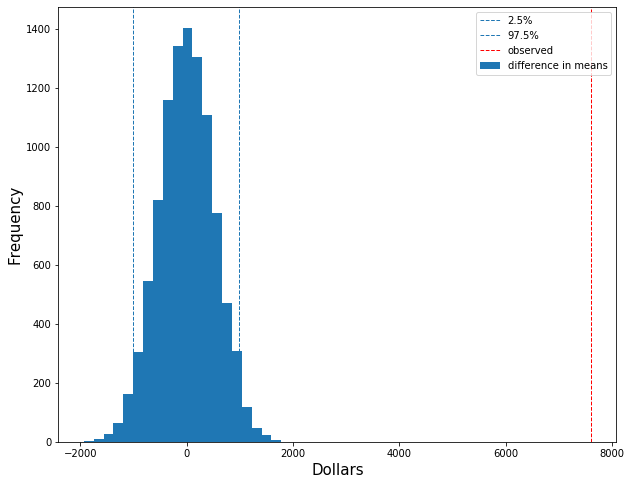

In [18]:
axvline_kwargs = {"linestyle" : "dashed", "linewidth" : "1"} 
plt.figure(figsize=(10,8))

plt.hist(perm_replicates, bins=20, label="difference in means")
plt.xlabel("Dollars", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.axvline(np.percentile(perm_replicates, [97.5]), **axvline_kwargs, label="2.5%")
plt.axvline(np.percentile(perm_replicates, [2.5]), **axvline_kwargs, label="97.5%")
plt.axvline(observed_diff, **axvline_kwargs, color="red", label="observed")
plt.legend(loc='upper right')
plt.show()

__Q:__ Consider the two variants of the _t_-test we performed in the previous assignment. Which one would you use now?

__A:__ By, "two variants", do you mean manually by formula vs. using `scipy.stats`? 

I would absolutely use `scipy.stats`. It's less prone or error cause by a mistake in parentheses, ordering of operations, or memory.

Or, by "two variants", do you mean assuming variance is the same or different? I would assume different.

__Q:__ If, instead of being asked whether the means of two groups were different, you were working with an ad-recommender team who wanted to release a new recommendation algorithm, and you were looking at click-through rate both for the current algorithm (call it A) and from trials of their new algorithm (call it B), would you perform a two-sided test as above? What would be your null and alternative hypotheses and what would be the real-world consequence of rejecting the null hypothesis?

__A:__ We should perform an A/B test.

The null hypohesis is, as usual, that nothing changes. There is no difference in clickthrough rate between algorithm A and algorithm B.

The alternative hypothesis is that there is a change. Se would like the change to be positive (higher click through rate).

The real-world consequence would be that we might replace algorithm A. If we are correct, he clickthrough rate will really increase and we might make more money. But it costs money to replace the recommendation algorithm, so we had better make enugh more to offset that.

# Learning outcomes

You've previously applied frequentist methods to calculate confidence intervals, p-values, and perform hypothesis tests. Frequentist methods use theoretical results to calculate what we expect would happen if experiments were to be run again and again and again. Now you've seen how you can do the same things using the bootstrap approach, which does not rely on such theory, and attendant assumptions, but instead literally does run experiments again and again and again.

In these exercises, you have:
* calculated the same confidence interval lower limit as you did previously
* tested the assumption that the variances of the two groups (insured vs. non-insured) were equal - something a bit harder to do using the frequentist method because of the nature of the sampling distribution for variance
* calculated the p-value for the difference between the means of the two groups and compared with the result obtained using the previous frequentist approach

You are now well equipped to apply the bootstrap approach to a wide variety of problems. Just think about what conditions you wish to recreate in your simulated reruns.

_hmmmmmmmmm_